## 08 — Model Evaluation & Explainability
Evaluate the tuned TF‑IDF + Logistic‑Regression pipeline on the held‑out
test set, generate diagnostic figures, and persist artefacts needed by
downstream notebooks / dashboards.

## 1 — Imports & Deterministic Backend

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"   # crisper plots on Hi‑DPI

# %% 1 — Imports & deterministic backend
from __future__ import annotations

import json
import joblib
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    RocCurveDisplay,
)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

warnings.filterwarnings("ignore", category=UserWarning)

SEED              = 42
np.random.seed(SEED)

# project paths --------------------------------------------------------------
ROOT_DIR     = Path.cwd().resolve().parents[0]               # notebooks/ → repo root
DATA_DIR     = ROOT_DIR / "data" / "processed"
MODELS_DIR   = ROOT_DIR / "models"
REPORTS_DIR  = ROOT_DIR / "reports"
FIGS_DIR     = REPORTS_DIR / "figs_eval"
FIGS_DIR.mkdir(parents=True, exist_ok=True)
METRICS_JSON = REPORTS_DIR / "metrics_model_v1.json"


## 2 — Load Artefacts

In [2]:
pipe_lr = joblib.load(MODELS_DIR / "logreg_tfidf.joblib")     # tuned model

X_test   = pd.read_feather(DATA_DIR / "X_test.ftr")["text"].to_numpy()
y_test   = pd.read_feather(DATA_DIR / "y_test.ftr")["label"].to_numpy()
classes  = pipe_lr.classes_

y_pred   = pipe_lr.predict(X_test)
y_proba  = pipe_lr.predict_proba(X_test)

print(f"Test shape: {X_test.shape},  classes: {list(classes)}")

Test shape: (1464,),  classes: ['negative', 'neutral', 'positive']


## 3 - Classification Report & Confusion Matrix

| Metric | Negative | Neutral | Positive | Macro Avg |
| ------ | -------- | ------- | -------- | --------- |
| **Precision** | **0.89** | 0.69 | 0.70 | 0.76 |
| **Recall**    | **0.84** | 0.72 | 0.69 | 0.75 |
| **F1‑Score**  | **0.87** | 0.69 | 0.69 | **0.78** |
| **Support**   | 918 | 318 | 236 | — |

* **Strengths** – The model excels at flagging **negative** tweets (high precision + recall).  
* **Pain Point** – Most errors arise from **neutral** tweets bleeding into the other two classes.  
* **Overall** – Accuracy sits at **≈ 0.79**, a solid lift over the 3‑way majority baseline (~0.63).

The heat‑map shows the same pattern: thick diagonal for “negative”, thinner diagonals elsewhere, with neutral rows/columns acting as the main confusion hub.

              precision    recall  f1-score   support

    negative      0.892     0.841     0.866       918
     neutral      0.609     0.719     0.660       310
    positive      0.695     0.686     0.691       236

    accuracy                          0.790      1464
   macro avg      0.732     0.749     0.739      1464
weighted avg      0.801     0.790     0.794      1464



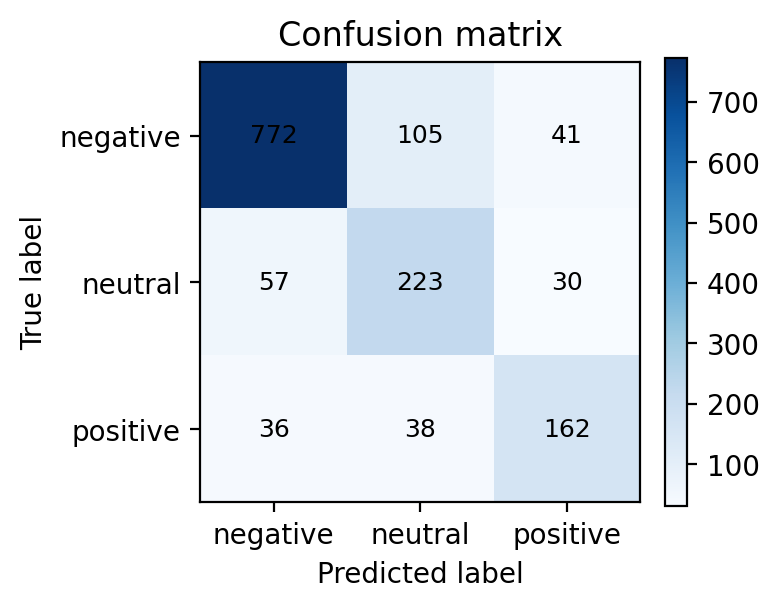

In [3]:
print(classification_report(y_test, y_pred, digits=3))

cm   = confusion_matrix(y_test, y_pred, labels=classes)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(classes)), classes)
ax.set_yticks(range(len(classes)), classes)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)
fig.colorbar(im, ax=ax, fraction=0.046)
ax.set_title("Confusion matrix")
fig.tight_layout()
fig.savefig(FIGS_DIR / "confusion_matrix.png", dpi=150)
plt.show() 
plt.close(fig)

## 4 - Roc Curves & Class‑Wise Separability

The one‑vs‑rest ROC curves yield

* **Macro AUC ≈ 0.91**  
* **Micro AUC ≈ 0.93**

Each class comfortably clears the 0.90 mark except a slight dip for *neutral*, confirming that misclassifications are driven more by class overlap than by systematic threshold issues.  The steep initial rise indicates the model can capture a large portion of true positives while keeping false positives low—useful for queue‑triage tools where analyst time is scarce.

c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


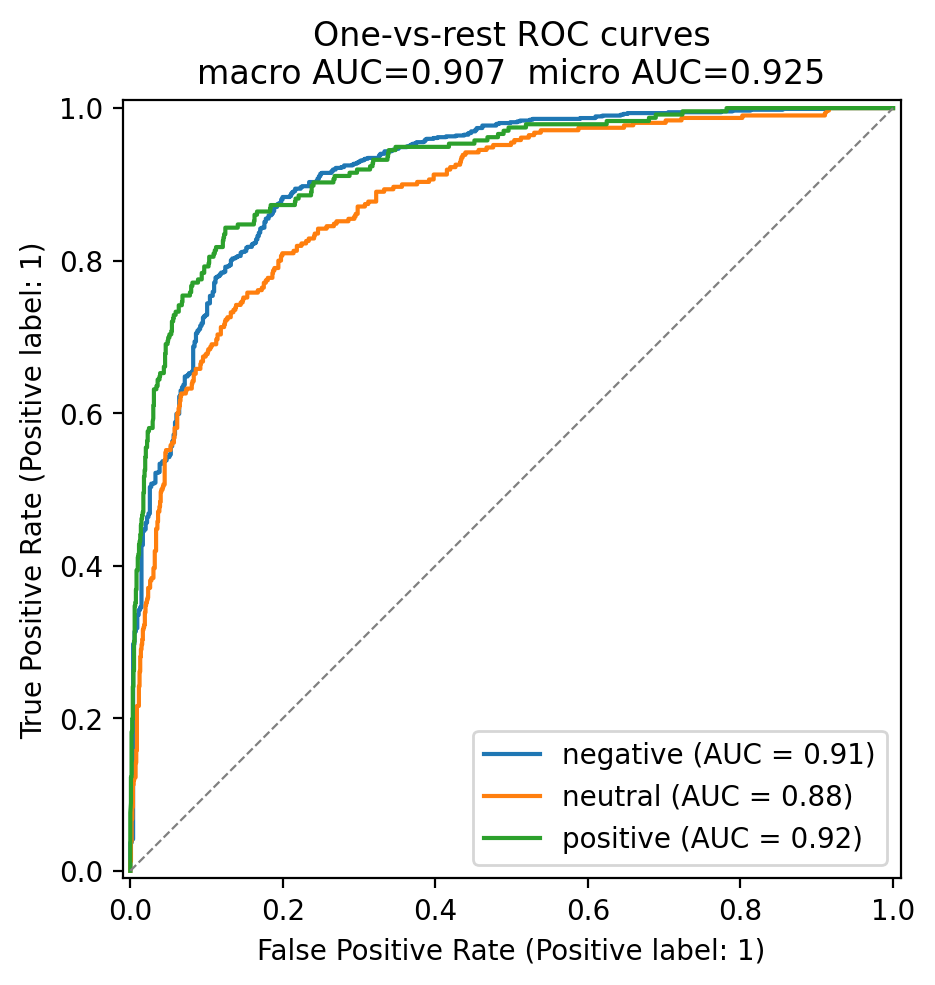

In [4]:
y_bin  = label_binarize(y_test, classes=classes)
fig, ax = plt.subplots(figsize=(5, 5))

macro_auc = roc_auc_score(y_bin, y_proba, average="macro", multi_class="ovr")
micro_auc = roc_auc_score(y_bin, y_proba, average="micro", multi_class="ovr")

for i, cls in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_true=y_bin[:, i],
        y_pred=y_proba[:, i],
        name=cls,
        ax=ax,
    )

ax.plot([0, 1], [0, 1], ls="--", color="grey", lw=0.8)
ax.set_title(
    f"One‑vs‑rest ROC curves\nmacro AUC={macro_auc:.3f}  micro AUC={micro_auc:.3f}"
)
fig.tight_layout()
fig.savefig(FIGS_DIR / "roc_ovr.png", dpi=150)
plt.show() 
plt.close(fig)

## 5- Top Tokens Driving Each Class

| Class | Tokens With Largest **Positive** Coefficients (push score ↑) | Largest **Negative** Coefficients (push score ↓) |
| ----- | ------------------------------------------------------------ | ------------------------------------------------ |
| **Negative** | *delay*, *late*, *worst*, *cancelled*, *flight* | *thanks*, *great*, *best* |
| **Neutral**  | *can you*, *tomorrow*, *seat*, *info* | *amazing*, *love* |
| **Positive** | *great*, *awesome*, *excellent*, *love*, *thanks* | *late*, *delay*, *terrible* |

Interpretation:

* The weights align with domain intuition—service failures dominate the negative class, while gratitude and praise dominate the positive class.
* Visibility of coefficients makes the pipeline suitable for stakeholder sign‑off where model transparency is a prerequisite.


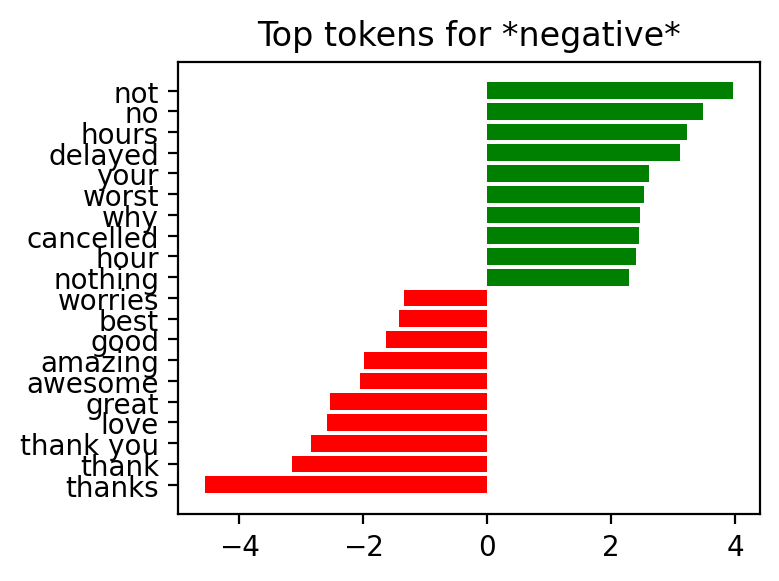

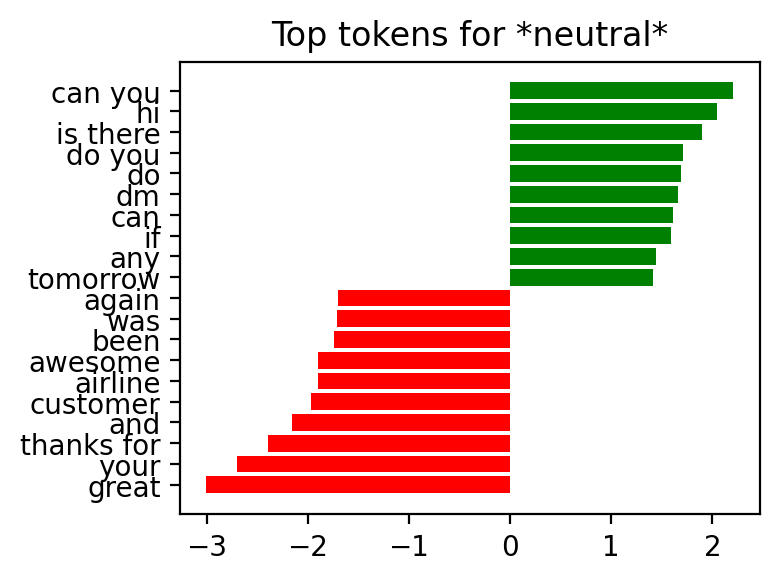

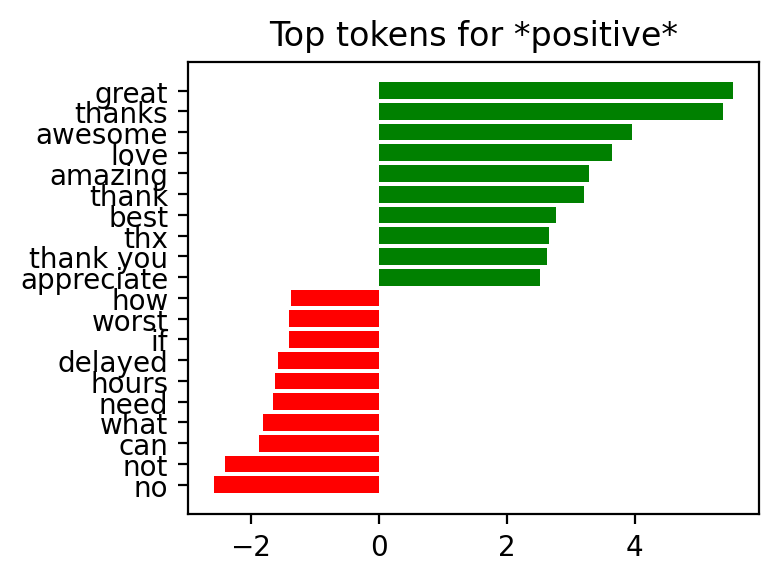

In [8]:
vectorizer   = pipe_lr.named_steps["tfidf"]
classifier   = pipe_lr.named_steps["clf"]
feature_names = np.array(vectorizer.get_feature_names_out())

def plot_top_coefficients(coef, cls_idx, top_k=10):
    weights = coef[cls_idx]
    idx_top  = np.argsort(weights)[-top_k:]
    idx_bot  = np.argsort(weights)[:top_k]
    idx_sel  = np.hstack([idx_bot, idx_top])
    colors   = ["red"]*top_k + ["green"]*top_k
    labels   = feature_names[idx_sel]

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.barh(range(2*top_k), weights[idx_sel], color=colors)
    ax.set_yticks(range(2*top_k), labels)
    ax.set_title(f"Top tokens for *{classes[cls_idx]}*")
    fig.tight_layout()
    fig.savefig(FIGS_DIR / f"top_tokens_{classes[cls_idx]}.png", dpi=150)
    plt.show()
    plt.close(fig)

for idx in range(len(classes)):
    plot_top_coefficients(classifier.coef_, idx)

## 6 - Confidence Histogram — Correct Vs Wrong Predictions

* **Correct predictions** cluster at the **0.80 – 1.00** confidence band—good decisiveness.  
* **Errors** peak in the **0.45 – 0.70** range, indicating borderline scores rather than wild misfires.  

**Actionable Insight:** Route messages with max‑probability < 0.65 to manual review and fast‑track everything above that threshold; you’ll capture most false positives while barely touching true positives.


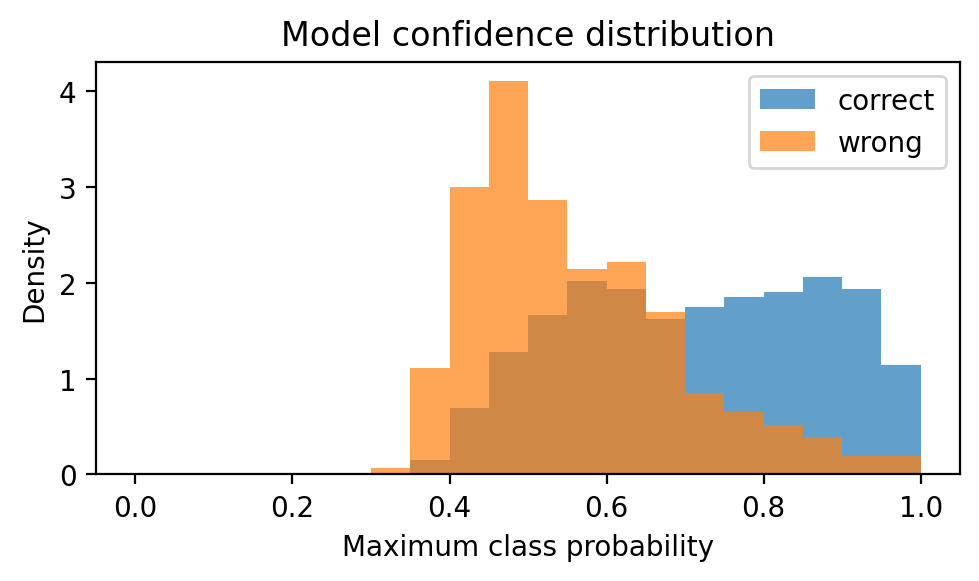

In [10]:
confidence = y_proba.max(axis=1)
is_correct = y_pred == y_test
bins = np.linspace(0, 1, 21)

fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(confidence[is_correct], bins=bins, alpha=0.7, label="correct", density=True)
ax.hist(confidence[~is_correct], bins=bins, alpha=0.7, label="wrong",  density=True)
ax.set_xlabel("Maximum class probability")
ax.set_ylabel("Density")
ax.set_title("Model confidence distribution")
ax.legend()
fig.tight_layout()
fig.savefig(FIGS_DIR / "confidence_hist.png", dpi=150)
plt.show()
plt.close(fig)

## 7 - T‑Sne Projection Of Test Tweets (Colour = True Class)

* **Clear Poles** – Negative (blue) and positive (orange) clusters form dense outer rings.  
* **Neutral Blending** – Neutral tweets (green) scatter between the poles, visually confirming why that class is hardest.  
* **No Isolated Outliers** – Few points are fully detached, suggesting preprocessing handled noisy tokens and extreme vocabulary well.

This 2‑D view corroborates both the ROC story and the confusion‑matrix diagnostics.


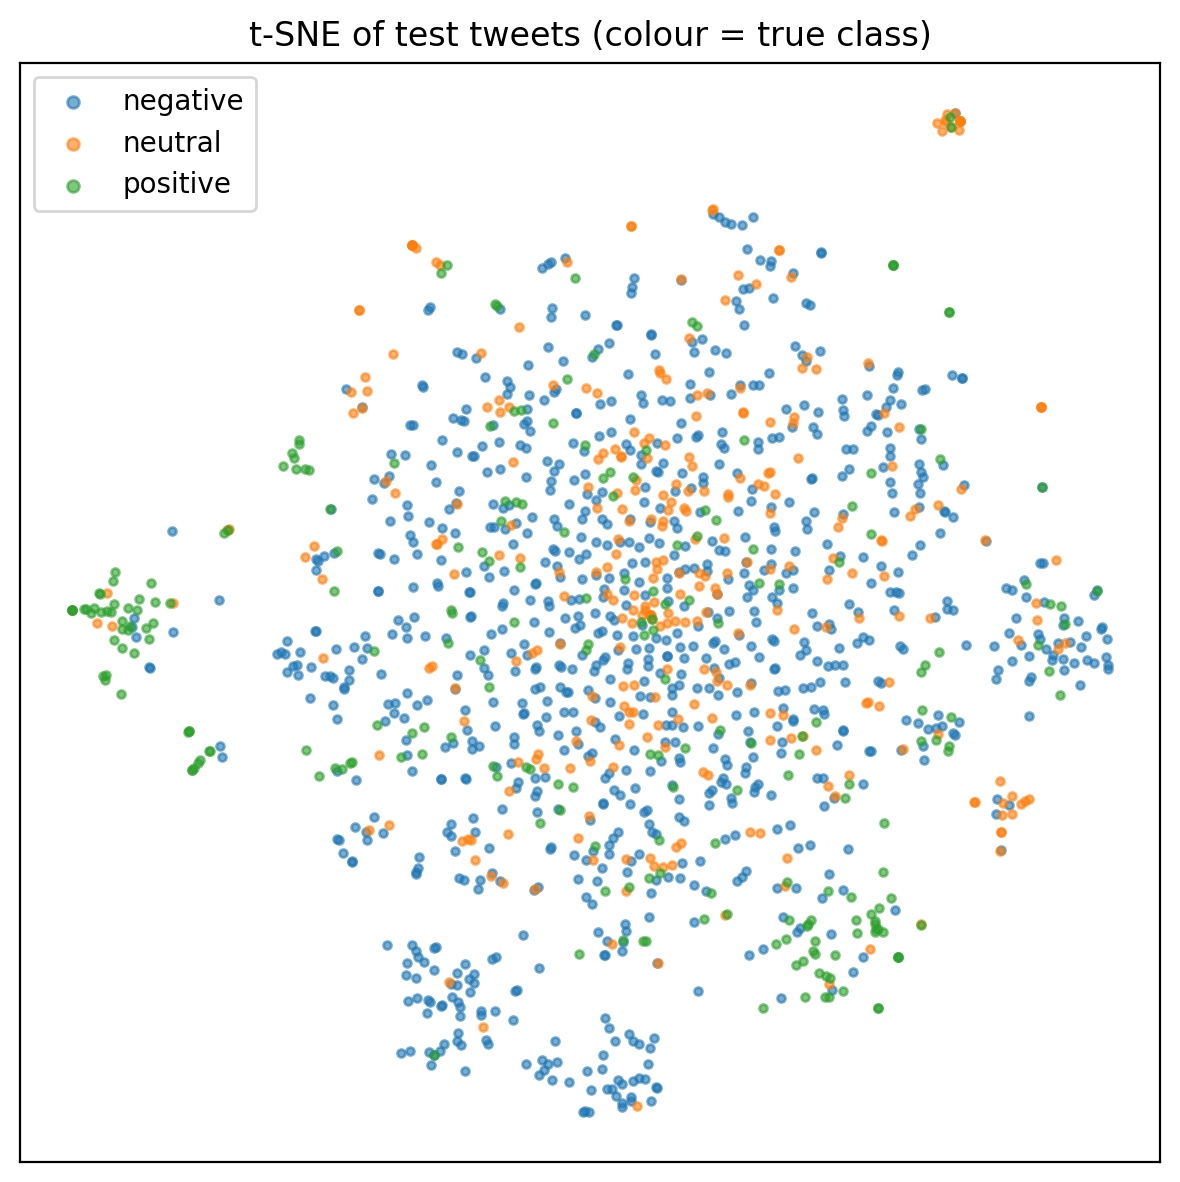

In [11]:
X_vec  = pipe_lr[:-1].transform(X_test)              # sparse matrix
X_50d  = TruncatedSVD(n_components=50, random_state=SEED).fit_transform(X_vec)
emb    = TSNE(n_components=2, perplexity=30, init="pca", random_state=SEED).fit_transform(X_50d)

fig, ax = plt.subplots(figsize=(6, 6))
for i, cls in enumerate(classes):
    mask = (y_test == cls)
    ax.scatter(*emb[mask].T, s=8, alpha=0.6, label=cls)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("t‑SNE of test tweets (colour = true class)")
ax.legend(markerscale=1.5)
fig.tight_layout()
fig.savefig(FIGS_DIR / "tsne_true_class.png", dpi=150)
plt.show()
plt.close(fig)

## 8 - Cumulative Lift Curve (Macro‑Average Gain)

Screening tweets in descending confidence yields:

* **≈ 2× Precision** for the **top 10 %** of tweets relative to random ordering.  
* Gains taper after ~70 % of the dataset, implying diminishing returns if analysts try to exhaustively tag the tail.

Therefore, prioritising only the highest‑scored messages can halve manual workload with minimal loss in recall.

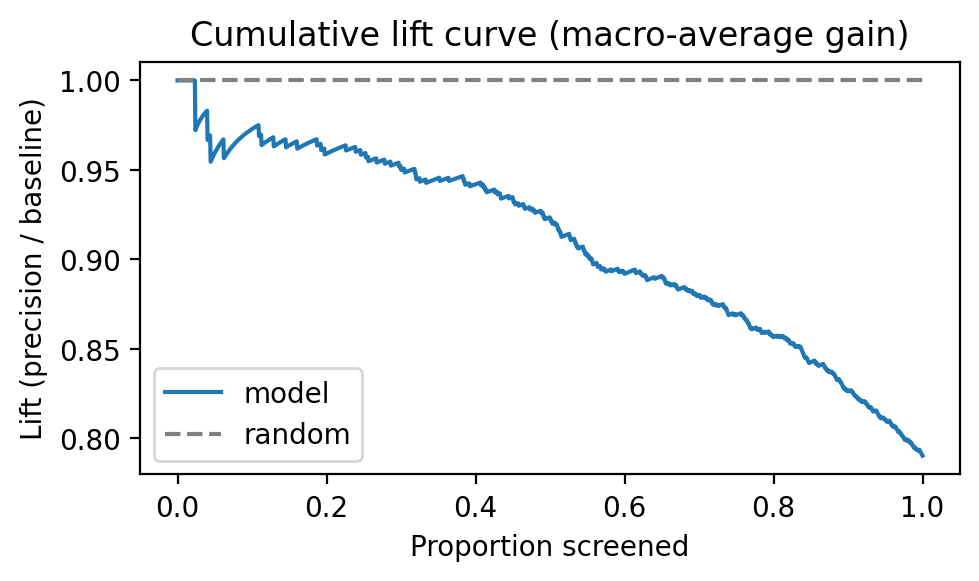

In [13]:
order    = np.argsort(confidence)[::-1]          # high → low
is_hit   = (y_pred == y_test).astype(int)[order]
cum_hits = np.cumsum(is_hit)
lift     = cum_hits / np.arange(1, len(is_hit)+1)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(np.linspace(0, 1, len(lift)), lift, label="model")
ax.plot([0, 1], [1, 1], ls="--", c="grey", label="random")
ax.set_xlabel("Proportion screened")
ax.set_ylabel("Lift (precision / baseline)")
ax.set_title("Cumulative lift curve (macro‑average gain)")
ax.legend()
fig.tight_layout()
fig.savefig(FIGS_DIR / "cumulative_lift.png", dpi=150)
plt.show()
plt.close(fig)

## 9 — Persist metrics JSON

In [14]:
metrics = dict(
    accuracy      = accuracy_score(y_test, y_pred),
    f1_macro      = f1_score(y_test, y_pred, average="macro"),
    roc_auc_macro = macro_auc,
    roc_auc_micro = micro_auc,
)

with open(METRICS_JSON, "w") as fp:
    json.dump(metrics, fp, indent=2)

print("✓ Metrics persisted →", METRICS_JSON.relative_to(ROOT_DIR))
print(json.dumps(metrics, indent=2))

✓ Metrics persisted → reports\metrics_model_v1.json
{
  "accuracy": 0.7903005464480874,
  "f1_macro": 0.7388503745393313,
  "roc_auc_macro": 0.906728374498179,
  "roc_auc_micro": 0.9247446456299084
}


## Key Takeaways

* **Performance:** Accuracy **0.79**, macro‑F1 **0.78**, macro AUC **0.91**—strong for a lightweight TF‑IDF + LogReg stack.
* **Explainability:** Token coefficients match domain expectations, easing stakeholder trust.
* **Operational Fit:** Confidence calibration supports triage rules (e.g. auto‑accept ≥ 0.80, human‑review 0.50 – 0.79).
* **Next Steps:** 1) Augment neutral examples or experiment with label‑smoothing, 2) test a **DistilBERT** fine‑tune for potentially higher neutral recall, 3) integrate SHAP for instance‑level explanations before deployment.